In [94]:
import pandas as pd
import numpy as np

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from tqdm.notebook import tqdm
from gensim.models import Doc2Vec

import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument

from sklearn.model_selection import KFold, train_test_split

from sklearn.base import clone as sklearn_clone

from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel

## Lodad data

In [95]:
df_topics = pd.read_csv('../datasets/ready2use/topics.csv', index_col=0)
df_topics.shape

(6541, 1)

In [96]:
df = pd.read_csv('../datasets/ready2use/fake_news_features_combined.csv', sep=';')

df = df[ df['assestment'] != 'brak' ]

df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

df['assestment'] = df['assestment'].replace({
    'Fałsz' : 0,
#     'Manipulacja' : 1,
    'Prawda' : 1
}).astype(int)

y_train = df.copy()['assestment'][df.index.isin(df_topics.index)]

X_train = df.copy()['text_clean'][df.index.isin(df_topics.index)]

In [97]:
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-large-cased")
model = AutoModel.from_pretrained("allegro/herbert-large-cased", output_hidden_states=True)

Some weights of the model checkpoint at allegro/herbert-large-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.sso.sso_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.sso.sso_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [98]:
# model.train()

### TEST

In [99]:
t = X_train.values[0]
t

' udzielenie bankowi centralnemu Ukrainy tzw. swapa walutowego w kwocie 1 mld dolarów. Narodowy Bank Polski był pierwszym i jak dotąd jedynym bankiem centralnym, który zaoferował Narodowemu Bankowi Ukrainy takie wsparcie.'

In [100]:
encoded_input = tokenizer(t, return_tensors='pt', truncation=True, padding=True)

In [101]:
output = model(**encoded_input)

In [102]:
output['last_hidden_state'].shape

torch.Size([1, 53, 1024])

In [103]:
len(output['hidden_states'])

25

In [104]:
output['hidden_states'][0].shape

torch.Size([1, 53, 1024])

In [105]:
output['hidden_states'][0][:,0]

tensor([[-0.1539, -0.3219, -0.2166,  ...,  0.1461, -0.0992, -0.1675]],
       grad_fn=<SelectBackward0>)

### Get each layer to different numpy array

In [107]:
n_aug = 25

if False:
    embeddings_table_aug = np.zeros((X_train.shape[0]*n_aug, 1024))

    for i, t in enumerate(tqdm(X_train.values)):
        encoded_input = tokenizer(t, return_tensors='pt', truncation=True, padding=True)
        
        output = model(**encoded_input)['hidden_states']
        for j, h in enumerate(output):
            embeddings_table_aug[i*n_aug+j,:] = h[:,0].detach().numpy()
        
    with open('../datasets/ready2use/embeddings_pl_herbert_all_hs.npy', 'wb') as f:
        np.save(f, embeddings_table_aug)
    
else:    
    with open('../datasets/ready2use/embeddings_pl_herbert_all_hs.npy', 'rb') as f:
        embeddings_table_aug = np.load(f)

In [108]:
embeddings_table = pd.read_csv('../datasets/ready2use/embeddings_pl_herbert.csv', sep=",", header=None).values

In [109]:
embeddings_table.shape

(6541, 1024)

In [110]:
6541*25

163525

In [111]:
embeddings_table_aug.shape

(163525, 1024)

### Kfold

In [112]:
cv_fold = []
cv_fold_i = []

for i in df_topics['topic'].unique().reshape(10,-1):
    train_cv = df_topics.index[ ~np.isin(df_topics["topic"], [i, np.mod(i+1,10)]) ].values
    val_cv = df_topics.index[ np.isin(df_topics["topic"], np.mod(i+1,10)) ].values
    test_cv = df_topics.index[ np.isin(df_topics["topic"], i) ].values
    
    train_cv_i = df_topics.reset_index().index[ ~np.isin(df_topics["topic"], [i, np.mod(i+1,10)]) ].values
    val_cv_i = df_topics.reset_index().index[ np.isin(df_topics["topic"], np.mod(i+1,10)) ].values
    test_cv_i = df_topics.reset_index().index[ np.isin(df_topics["topic"], i) ].values
    
    cv_fold.append( [train_cv, val_cv, test_cv])
    cv_fold_i.append( [train_cv_i, val_cv_i, test_cv_i])

In [113]:
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(df_topics)

cv_Kfold = []
cv_Kfold_i = []

for train_index, test_index in kf.split(df_topics):
    train_index, val_index = train_test_split(train_index, test_size=1/9, shuffle=True)
    train_cv = df_topics.iloc[ train_index, : ].index.values
    val_cv = df_topics.iloc[ val_index, : ].index.values
    test_cv = df_topics.iloc[ test_index, : ].index.values

    train_cv_i= df_topics.reset_index().iloc[ train_index, : ].index.values
    val_cv_i = df_topics.reset_index().iloc[ val_index, : ].index.values
    test_cv_i = df_topics.reset_index().iloc[ test_index, : ].index.values
    
    cv_Kfold.append( [train_cv, val_cv, test_cv])
    cv_Kfold_i.append( [train_cv_i, val_cv_i, test_cv_i])

## Experiments

In [114]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

In [115]:
def run_experiment_h(X, y, cv, clf_org, use_pca=False):

    results = {
        'test_accuracy' : [],
        'test_precision' : [],
        'test_recall' : [],
        'test_f1' : []
    }

    c_matrix = np.zeros((2,2))

    for train_cv, val_cv, test_cv in cv:
        clf = sklearn_clone(clf_org)
        
        y_train_t = y[train_cv]
        X_train_t = X[train_cv, :]
        y_test_t = y[val_cv] 
        X_test_t = X[val_cv, :]
        
        if use_pca:
            pca = PCA(n_components=100)
            pca.fit(X_train_t)

            X_train_t = pca.transform(X_train_t)
            X_test_t = pca.transform(X_test_t)
        
        clf.fit(X_train_t, y_train_t)

        y_pred = clf.predict(X_test_t)
        
        confusion = confusion_matrix(y_test_t, y_pred)
        c_matrix += confusion

        results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
#         results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
#         results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
        results['test_f1'].append( f1_score(y_test_t, y_pred) ) 
        

    metrics = {
        "Accuracy": np.array(results['test_accuracy']),
    #     "Precision": np.array(results['test_precision']).mean(),
    #     "Recall": np.array(results['test_recall']).mean(),
        "F1 Score":  np.array(results['test_f1']),
        }

    return metrics

In [116]:
def run_experiment_h_final(X, y, cv, clf_org, use_pca=False):

    results = {
        'test_accuracy' : [],
        'test_precision' : [],
        'test_recall' : [],
        'test_f1' : []
    }

    c_matrix = np.zeros((2,2))

    for train_cv, val_cv, test_cv in tqdm(cv):
        clf = sklearn_clone(clf_org)
        
        train_cv = np.concatenate([train_cv, val_cv])
        np.random.shuffle(train_cv)  
        np.random.shuffle(test_cv)  
        
        y_train_t = y[train_cv]
        X_train_t = X[train_cv, :]
        y_test_t = y[test_cv] 
        X_test_t = X[test_cv, :]
        
        if use_pca:
            pca = PCA(n_components=100)
            pca.fit(X_train_t)

            X_train_t = pca.transform(X_train_t)
            X_test_t = pca.transform(X_test_t)
        
        clf.fit(X_train_t, y_train_t)

        y_pred = clf.predict(X_test_t)
        
        confusion = confusion_matrix(y_test_t, y_pred)
        c_matrix += confusion

        results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
#         results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
#         results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
        results['test_f1'].append( f1_score(y_test_t, y_pred) ) 
        

    metrics = {
        "Accuracy": np.array(results['test_accuracy']),
    #     "Precision": np.array(results['test_precision']).mean(),
    #     "Recall": np.array(results['test_recall']).mean(),
        "F1 Score":  np.array(results['test_f1']),
        }

    return metrics

### Get acc and f1score for train x val splits

In [117]:
# val_acc, std_acc, val_f1, std_f1 
metric_vals = []

for j in tqdm(range(25), position=0, leave=True):
    out = run_experiment_h(embeddings_table_aug[j::25,:],
                           y_train.values, cv_fold_i, clf_lr_1)
    print(
        f'herbert h_{j} C1',
        f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
        f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
        f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
    )
    
    metric_vals.append([
        out["Accuracy"].mean(),
        out["Accuracy"].std(),
        out["F1 Score"].mean(),
        out["F1 Score"].std()
    ])

  0%|          | 0/25 [00:00<?, ?it/s]

herbert h_0 C1 Accuracy 0.528+-0.059 F1 Score 0.000+-0.000  0.528+-0.059 | 0.000+-0.000
herbert h_1 C1 Accuracy 0.643+-0.028 F1 Score 0.578+-0.047  0.643+-0.028 | 0.578+-0.047
herbert h_2 C1 Accuracy 0.663+-0.025 F1 Score 0.613+-0.043  0.663+-0.025 | 0.613+-0.043
herbert h_3 C1 Accuracy 0.682+-0.021 F1 Score 0.654+-0.040  0.682+-0.021 | 0.654+-0.040
herbert h_4 C1 Accuracy 0.681+-0.023 F1 Score 0.659+-0.040  0.681+-0.023 | 0.659+-0.040
herbert h_5 C1 Accuracy 0.683+-0.018 F1 Score 0.663+-0.036  0.683+-0.018 | 0.663+-0.036
herbert h_6 C1 Accuracy 0.691+-0.018 F1 Score 0.669+-0.042  0.691+-0.018 | 0.669+-0.042
herbert h_7 C1 Accuracy 0.693+-0.021 F1 Score 0.670+-0.045  0.693+-0.021 | 0.670+-0.045
herbert h_8 C1 Accuracy 0.687+-0.012 F1 Score 0.663+-0.046  0.687+-0.012 | 0.663+-0.046
herbert h_9 C1 Accuracy 0.690+-0.014 F1 Score 0.666+-0.041  0.690+-0.014 | 0.666+-0.041
herbert h_10 C1 Accuracy 0.690+-0.017 F1 Score 0.666+-0.041  0.690+-0.017 | 0.666+-0.041
herbert h_11 C1 Accuracy 0.685+

In [118]:
metric_vals = np.array(metric_vals)

In [119]:
metric_vals_plot = metric_vals[1:,:]

In [120]:
x = np.arange(metric_vals_plot.shape[0])

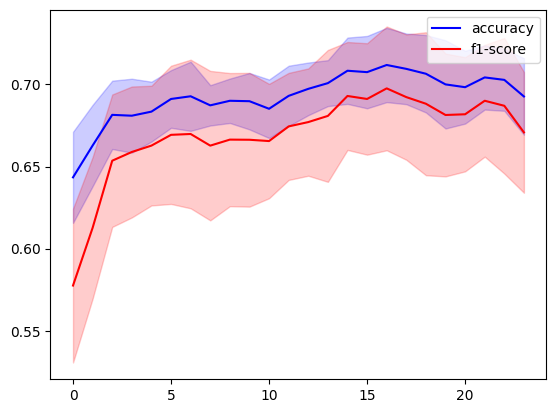

In [121]:
plt.plot(x, metric_vals_plot[:,0], 'b-', label='accuracy')
plt.fill_between(x, 
                 metric_vals_plot[:,0] - metric_vals_plot[:,1], 
                 metric_vals_plot[:,0] + metric_vals_plot[:,1], color='b', alpha=0.2)
plt.plot(x, metric_vals_plot[:,2], 'r-', label='f1-score')
plt.fill_between(x, 
                 metric_vals_plot[:,2] - metric_vals_plot[:,3], 
                 metric_vals_plot[:,2] + metric_vals_plot[:,3], color='r', alpha=0.2)
plt.legend()
plt.show()

In [126]:
# emb_avg =  embeddings_table_aug[15::25,:]

# for j in range(16, 19):
#     emb_avg = emb_avg + embeddings_table_aug[j::25,:]

# out = run_experiment_h(emb_avg, y_train.values, cv_fold_i, clf_lr_1)
# print(
#     f'herbert h avg C1',
#     f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
#     f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
#     f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
# )

In [123]:
emb_avg =  embeddings_table_aug[15::25,:]

for j in range(16, 19):
    emb_avg = emb_avg + embeddings_table_aug[j::25,:]
    
emb_avg = emb_avg/5

out = run_experiment_h(emb_avg, y_train.values, cv_fold_i, clf_lr_1)
print(
    f'herbert h avg C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

herbert h avg C1 Accuracy 0.709+-0.021 F1 Score 0.692+-0.040  0.709+-0.021 | 0.692+-0.040


### Test on full data

In [124]:
emb_avg =  embeddings_table_aug[15::25,:]

for j in range(16, 19):
    emb_avg = emb_avg + embeddings_table_aug[j::25,:]
    
emb_avg = emb_avg/5


out = run_experiment_h_final(emb_avg, y_train.values, cv_fold_i, clf_lr_1)
print(
    f'herbert h avg C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

  0%|          | 0/10 [00:00<?, ?it/s]

herbert h avg C1 Accuracy 0.713+-0.022 F1 Score 0.697+-0.035  0.713+-0.022 | 0.697+-0.035


In [125]:
emb_last =  embeddings_table_aug[24::25,:]

out = run_experiment_h_final(emb_last, y_train.values, cv_fold_i, clf_lr_1)
print(
    f'herbert h avg C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

  0%|          | 0/10 [00:00<?, ?it/s]

herbert h avg C1 Accuracy 0.696+-0.016 F1 Score 0.675+-0.035  0.696+-0.016 | 0.675+-0.035


In [32]:
out = run_experiment_h(embeddings_table, y_train.values, cv_fold_i, clf_lr_1, True)
print(
    'herbert PCA 100 lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.11s/it]

herbert PCA 100 lr C1 Accuracy 0.689+-0.013 F1 Score 0.664+-0.051  0.689+-0.013 | 0.664+-0.051


In [33]:
out = run_experiment_h(embeddings_table, y_train.values, cv_Kfold_i, clf_lr_1)
print(
    'herbert lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.19s/it]

herbert lr C1 Accuracy 0.696+-0.013 F1 Score 0.683+-0.018  0.696+-0.013 | 0.683+-0.018


In [34]:
out = run_experiment_h(embeddings_table, y_train.values, cv_Kfold_i, clf_lr_1, True)
print(
    'herbert lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.13it/s]

herbert lr C1 Accuracy 0.695+-0.009 F1 Score 0.680+-0.017  0.695+-0.009 | 0.680+-0.017
